In [8]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm
import os
import seaborn as sns
import random
import math
import scipy as sp
import itertools
sns.set(style="whitegrid")

Load and check data:

In [9]:
alldata = pd.read_csv("data/error_data.csv")

In [10]:
alldata.head()

,participant,phase,condition,cue,target,response,rt,correct,Column1,Column2
0,1001.0,learn,1.0,EMPIRE,STATE,KING,3457.0,2.0,NaN,NaN
1,1001.0,learn,1.0,CHUNK,BLOCK,HUNK,3361.0,2.0,NaN,NaN
2,1001.0,learn,1.0,GLIDE,HANG,FLY,2177.0,2.0,NaN,NaN
3,1001.0,learn,1.0,SAIL,OCEAN,BOAT,2341.0,2.0,NaN,NaN
4,1001.0,learn,1.0,ELEVATOR,BUILDING,UP,3464.0,2.0,NaN,NaN


In [11]:
alldata.shape

(5670, 10)

In [12]:
# remove rows with all nan
alldata = alldata.dropna(how='all')
alldata.shape

(5490, 10)

# Log likelihood

Implement ACT-R code:

In [27]:
def activation(traces, time, decay):
    """Computes the activation of a memory given its history of retrievals"""
    ftraces = [x for x in traces if x < time]
    decay = max(0, decay)  # Allows no positive decay rates in equation 
    decay - min(decay, 5)
    times = time - np.array(ftraces)
    odds = times ** -decay
    return np.log(np.sum(odds))

activation([5, 10, 15], 40, 0.5)

-0.5949230018850301

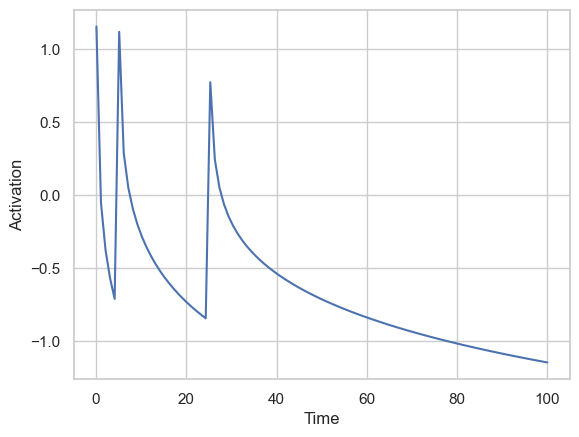

In [28]:
time = np.linspace(0.1, 100, 100)
traces = [0.001, 5, 25]
y = []
for t in time:
    act = activation(traces, t, 0.5)
    y += [act]
    
plt.plot(time, y)
plt.xlabel("Time")
plt.ylabel("Activation")
plt.show()

Create loglikelihood function for the model

In [29]:
def boltzmann(options, values, temperature):
    """Returns a Boltzmann distribution of the probabilities of each option"""
    temperature = max(temperature, 0.01) 
    vals = np.array(values)/temperature
    #bvals = np.exp(vals)/np.sum(np.exp(vals))
    bvals = np.exp(vals - np.max(vals)) / np.exp(vals - np.max(vals)).sum()
    return dict(zip(options, bvals))

In [30]:
boltzmann([2,3], [1, 0.7], 1)

{2: 0.574442516811659, 3: 0.425557483188341}

Create a loglikelihood function for the elaborative model, each error item is given additional spreading activation given the max association (mas) parameter

### Complete *elaborative* model

In [31]:
def LLelab(alldata, ppt, decay, temp, mas=1.6):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    data = alldata[alldata.participant == ppt]

    # create a list of error items
    errors = data[data.condition == 1].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    # since we don't have data for when study items were presented in each participant's learning phase
    # we will use the presentation of the error items and interleaven the study items in between
    pos = 1
    present = study[:]
    for word in errors:
        present.insert(pos, word)
        pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 1
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase


    # model testing phase
    LL = 0
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
      # Calculate log likelihood of response- possible options are 19 random integers
      # or correct associate
      options = DM[cue].keys()
      # create spreading activation additional error component given size of cue's dec mem
      cueMem = len(DM[cue])
      add = (mas - np.log((cueMem + 1)/2)) - (mas - np.log((cueMem + 1)/1))
      # if error condition, add spreading activation
      values = [activation(DM[cue][opt], time, decay) if condition == 1 else 
       (activation(DM[cue][opt], time, decay) + add) for opt in options]
      prob = boltzmann(options, values, temp)[response]
    
      # Sum up the LLs
      LL += np.log(max(prob, 10e-10))

       # add time taken to responde
      time += rt/1000
    
    return LL

In [32]:
LLelab(alldata, 1001, 0.5, 1, 1.6)

-172.73898573437492

In [33]:
LLelab(alldata, 1001, 0.5, 1, 4)

-172.73898573437492

Create a loglikelihood function of the mediator model, where there are two routes to make a decision: To remember something that worked and to remember something that did not.

In [34]:
def LLmed(data, decay, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
    errors = data[data.phase == "learn"].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    pos = 1
    present = errors[:]
    for i in range(len(errors)):
      word = study[i]
      present.insert(pos, word)
      pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 1
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase

    # model testing phase
    LL = 0
    
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
        # Calculate log likelihood of response- possible options are 19 random integers
        # or correct associate
        options = DM[cue].keys()
        # create spreading activation additional error component given size of cue's dec mem
        cueMem = len(DM[cue])
        # if error condition, add spreading activation
        values = [activation(DM[cue][opt], time, decay) for opt in options]
        prob1 = boltzmann(options, values, temp)[response]
        
        # probability of retrieving error memory
        if condition == 1:
          error = errorResp[cue]
          prob2 = boltzmann(options, values, temp)[error]
        else:
          prob2 = 0
        
        # Sum up the LLs
        LL += np.log(max(prob1 + prob2, 10e-10))
        
         # add time taken to responde
        time += rt/1000
        
    return LL

In [35]:
LLmed(alldata[alldata.participant == 1001], 0.5, 1)

-148.37730418310719

In [36]:
LLmed(alldata[alldata.participant == 1002], 0.5, 1)

-150.8797807573661

# Create RT models

In [37]:
def responsetime(activation, ter, F=1, f=1):
    return ter + F * np.exp(-f * activation)

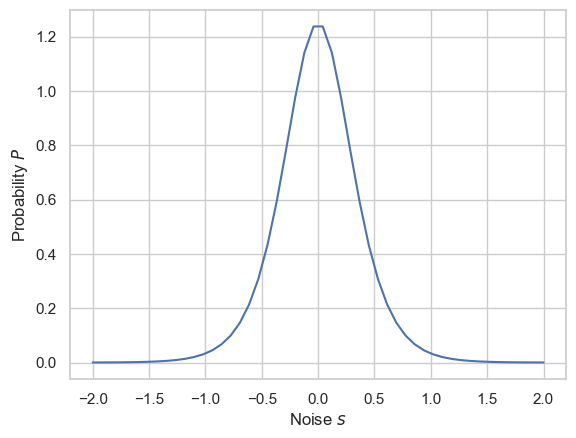

In [38]:
noise = np.linspace(-2, 2)
dist = sp.stats.logistic(0, 0.2)
plt.plot(noise, dist.pdf(noise))
plt.xlabel("Noise $s$")
plt.ylabel("Probability $P$")
plt.show()

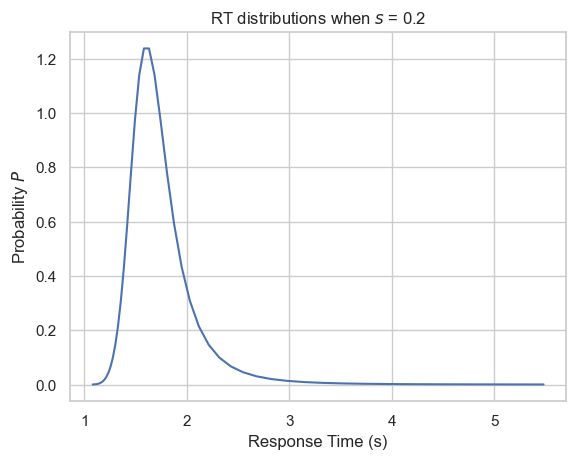

In [39]:
rts = [responsetime((0.5 - x), 1) for x in noise]
plt.plot(rts, dist.pdf(noise))
plt.xlabel("Response Time (s)")
plt.ylabel("Probability $P$")
plt.title("RT distributions when $s$ = 0.2")
plt.show()

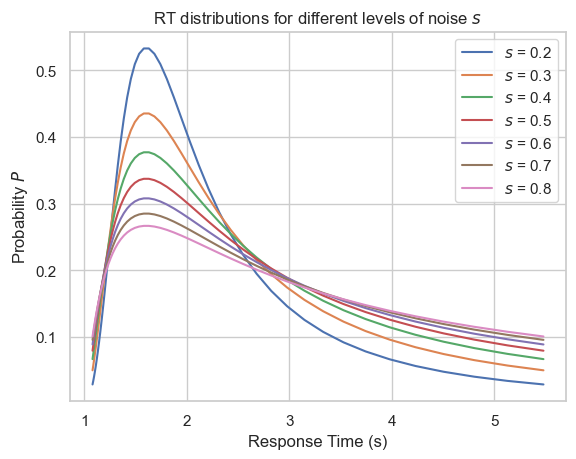

In [40]:
for s in np.linspace(0.2, 0.8, 7):
    dist = sp.stats.logistic(0, (math.sqrt((math.pi**2)*s)/3))
    rts = [responsetime((0.5 - x), 1) for x in noise]
    plt.plot(rts, dist.pdf(noise))
plt.legend(["$s$ = %.1f" % (x,) for x in np.linspace(0.2, 0.8, 7)])
plt.xlabel("Response Time (s)")
plt.ylabel("Probability $P$")
plt.title("RT distributions for different levels of noise $s$")
plt.show()

## Updated noise SD added here

In [41]:
from urllib.request import proxy_bypass
def rtProb(activation, s, ter, rt=None):
  """Takes one parameter for noise, s, and outputs a probability distribution for response times"""
  noise = np.linspace(-2, 2)
  dist = sp.stats.logistic(0, (math.sqrt((math.pi**2)*s)/3))
  rts = [responsetime((activation - x), ter) for x in noise]
  prob = dist.pdf(noise)
  rtprob = {rts[i]:prob[i]for i in range(len(noise))}
  if rt:
    val = min(rtprob.keys(), key=lambda x: abs(x - (rt/1000)))
    return rtprob[val]
  else:
    return rtprob

In [42]:
rtProb(3, 1, 1, rt = 1050)

0.23864176792866348

## Elaborative Model

In [43]:
def LLelabRT(alldata, decay, temp, ter, ppt='sim', mas = 1.6):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    data = alldata[alldata.participant == ppt]

    # create a list of error items
    errors = data[data.condition == 1].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    pos = 1
    present = errors[:]
    present = study[:]

    for word in errors:
        present.insert(pos, word)
        pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 1
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase


    # model testing phase
    LL = 0
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
      # Calculate log likelihood of response- possible options are 19 random integers
      # or correct associate
      options = DM[cue].keys()
      # create spreading activation additional error component given size of cue's dec mem
      cueMem = len(DM[cue])
      add = (mas - np.log((cueMem + 1)/2)) - (mas - np.log((cueMem + 1)/1))
      # if error condition, add spreading activation
      values = [(activation(DM[cue][opt], time, decay) + add) if condition == 1 else 
       activation(DM[cue][opt], time, decay) for opt in options]
      prob = boltzmann(options, values, temp)[response]
    
      # now calculate response times:
      if condition == 1:
        resp_activation = activation(DM[cue][response], time, decay) + add
      else: 
        resp_activation = activation(DM[cue][response], time, decay)
      
      prob_rt = rtProb(resp_activation, temp, ter, rt=rt)

      # Sum up the LLs
      LL += (np.log(max(prob, 10e-10)) + np.log(max(prob_rt, 10e-10)))

       # add time taken to responde
      time += rt/1000
    
    return LL

In [44]:
LLelabRT(alldata, 0.5, 1, 1, ppt=1001)

-285.98920769327106

In [45]:
LLelabRT(alldata, 0.5, 1, 1, ppt=1002)

-298.55672775778953

## Mediator Model

## Updated noise SD *also* added here

In [46]:
from urllib.request import proxy_bypass
def rtProb2(resp_activation, error_activation, condition, s, ter, rt=None):
  """Takes one parameter for noise, s, and outputs a probability distribution for response times"""
  noise = np.linspace(-2, 2)
  dist = sp.stats.logistic(0, (math.sqrt((math.pi**2)*s)/3))
  if condition == 1:
    rts = [(responsetime((resp_activation - x), ter) + responsetime((error_activation - x), ter)) for x in noise]
  else: 
    rts = [responsetime((resp_activation - x), ter) for x in noise]
  prob = dist.pdf(noise)
  rtprob = {rts[i]:prob[i]for i in range(len(noise))}
  if rt:
    val = min(rtprob.keys(), key=lambda x: abs(x - (rt/1000)))
    return rtprob[val]
  else:
    return rtprob

In [47]:
rtProb2(3, 2, 1, 0.2, 1, rt=6100)

0.029021222079091556

In [48]:
def LLmedRT(alldata, decay, temp, ter, ppt='sim'):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    data = alldata[alldata.participant == ppt]
    
    # create a list of error items
    errors = data[data.condition == 1].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    pos = 1
    present = study[:]

    for word in errors:
        present.insert(pos, word)
        pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 1
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase

    # model testing phase
    LL = 0
    
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
        # Calculate log likelihood of response- possible options are 19 random integers
        # or correct associate
        options = DM[cue].keys()

        # calculate probability of retrieving given response
        values = [activation(DM[cue][opt], time, decay) for opt in options]
        prob1 = boltzmann(options, values, temp)[response]
        
        # probability of retrieving error memory
        if condition == 1:
          error = errorResp[cue]
          prob2 = boltzmann(options, values, temp)[error]
        else:
          prob2 = 0
        
        # add response times calculations
        # probability of given response time with
        respAct = activation(DM[cue][response], time, decay)
        if condition == 1:
          error = errorResp[cue]
          errorAct = activation(DM[cue][error], time, decay)
          prob_rt = rtProb2(rt, respAct, errorAct, condition, temp, ter)
        else:
          errorAct = 0
          prob_rt = rtProb2(rt, respAct, errorAct, condition, temp, ter)

        # Sum up the LLs
        LL += (np.log(max(prob1 + prob2, 10e-10)) + np.log(max(prob_rt, 10e-10)))
        
         # add time taken to responde
        time += rt/1000
        
    return LL

In [49]:
LLmedRT(alldata, 0.5, 1, 1, ppt=1001)

-279.07359732291604

In [50]:
LLmedRT(alldata, 0.7, 0.25, 0.5, ppt=1002)

-226.34704529241907

# Optimizing the Models

## Elaborative Optimization

In [51]:
def vLLelab(array):
    """Vector function of procedural log-likelihood"""
    global data
    decay, temp, ter = array
    return -1 * LLelabRT(data, decay, temp, ter)

## Mediator Optimization

In [52]:
def vLLmed(array):
    """Vector function of procedural log-likelihood"""
    global data
    decay, temp, ter = array
    return -1 * LLmedRT(data, decay, temp, ter)

# Calculate LL for each ppt and assign best model

## compute the best parameters and high log-liklihoods of each model for each participant

In [32]:
alldata.participant.unique()

array([1001., 1002., 1003., 1004., 1005., 1006., 1007., 1008., 1009.,
       1010., 1011., 1012., 1013., 1014., 1015., 1016., 1017., 1018.,
       1019., 1020., 1021., 1022., 1023., 1024., 1025., 1026., 1028.,
       1029., 1031., 1032., 1033., 1035., 1036., 1037., 1038., 1039.,
       1040., 1041., 1042., 1043., 1044., 1045., 1046., 1047., 1049.,
       1050., 1051., 1053., 1054., 1055., 1056., 1057., 1058., 1059.,
       1061., 1063., 1064., 1065., 1067., 1068., 1069.])

In [34]:
DO_ALL = False
dataframe = []

#from pybads import BADS


if DO_ALL:
    for ppt in alldata.participant.unique(): 
        data = alldata[alldata.participant == ppt]
        eres = opt.minimize(vLLelab, x0 = [0.5, 1, 1], method = "Powell", bounds=[[0.4, 0.6], [0, 1], [0.1, 4]])
        edecay, etemp, eter = eres.x
        llelab = LLelabRT(data, edecay, etemp, eter, ppt=ppt)
            
        mres = opt.minimize(vLLmed, x0 = [0.5, 1, 1], method = "Powell", bounds=[[0.4, 0.6], [0, 1], [0.1, 4]])
        mdecay, mtemp, mter = mres.x
        llmed = LLmedRT(data, mdecay, mtemp, mter, ppt=ppt)

        print("%s : %d, %d" % (ppt, llelab, llmed))
        best = "Mediator"
        if llelab > llmed:
            best = "Elaborative"
            
        diff = llmed - llelab
            
        row = [ppt, edecay, etemp, eter, llelab, mdecay, mtemp, mter, llmed, best, diff]
            
        dataframe += [row]

    result = pd.DataFrame(dataframe, columns=["Participant", "elab.decay", "elab.temp", "elab.ter", "elab.LL", "med.decay", "med.temp", "med.ter", "med.LL", "best.model", "diff.LL"])

1001.0 : -178, -157
1002.0 : -190, -160
1003.0 : -185, -156
1004.0 : -198, -167
1005.0 : -171, -146
1006.0 : -181, -155
1007.0 : -175, -150
1008.0 : -164, -150
1009.0 : -163, -143
1010.0 : -163, -142
1011.0 : -186, -158
1012.0 : -183, -161
1013.0 : -181, -158
1014.0 : -183, -159
1015.0 : -222, -183
1016.0 : -170, -150
1017.0 : -183, -158
1018.0 : -172, -148
1019.0 : -195, -163
1020.0 : -162, -142
1021.0 : -186, -162
1022.0 : -182, -160
1023.0 : -182, -157
1024.0 : -176, -151
1025.0 : -171, -145
1026.0 : -168, -146
1028.0 : -165, -143
1029.0 : -193, -165
1031.0 : -164, -145
1032.0 : -219, -182
1033.0 : -184, -157
1035.0 : -165, -145
1036.0 : -171, -149
1037.0 : -162, -140
1038.0 : -165, -143
1039.0 : -177, -153
1040.0 : -192, -162
1041.0 : -181, -157
1042.0 : -173, -150
1043.0 : -166, -148
1044.0 : -161, -139
1045.0 : -169, -147
1046.0 : -173, -150
1047.0 : -160, -138
1049.0 : -172, -150
1050.0 : -182, -160
1051.0 : -170, -155
1053.0 : -179, -159
1054.0 : -175, -152
1055.0 : -192, -166


In [35]:
LLelabRT(data, 0.1, 0.5, 0, ppt=1069)

-156.53896797422578

In [36]:
alldata.participant.unique()

array([1001., 1002., 1003., 1004., 1005., 1006., 1007., 1008., 1009.,
       1010., 1011., 1012., 1013., 1014., 1015., 1016., 1017., 1018.,
       1019., 1020., 1021., 1022., 1023., 1024., 1025., 1026., 1028.,
       1029., 1031., 1032., 1033., 1035., 1036., 1037., 1038., 1039.,
       1040., 1041., 1042., 1043., 1044., 1045., 1046., 1047., 1049.,
       1050., 1051., 1053., 1054., 1055., 1056., 1057., 1058., 1059.,
       1061., 1063., 1064., 1065., 1067., 1068., 1069.])

In [ ]:
if DO_ALL:
    result.to_csv("LL_model1.csv")
else:
    result = pd.read_csv("LL_model1.csv")
result

In [37]:
result.dropna()

,Participant,elab.decay,elab.temp,elab.ter,elab.LL,med.decay,med.temp,med.ter,med.LL,best.model,diff.LL
0,1001.0,0.599944,0.999934,3.999939,-178.324259,0.599944,0.999934,3.999939,-157.240344,Mediator,21.083915
1,1002.0,0.599944,0.999934,3.999939,-190.043829,0.599944,0.999934,3.999939,-160.804285,Mediator,29.239544
2,1003.0,0.599944,0.999934,3.999939,-185.253134,0.599944,0.999934,3.999939,-156.991858,Mediator,28.261276
3,1004.0,0.599944,0.999934,3.999939,-198.593962,0.599944,0.999934,3.999939,-167.204123,Mediator,31.389838
4,1005.0,0.599944,0.999934,3.999939,-171.181455,0.599944,0.999934,3.999939,-146.153654,Mediator,25.027801
...,...,...,...,...,...,...,...,...,...,...,...
56,1064.0,0.599944,0.999934,3.999939,-160.130752,0.599944,0.999934,3.999939,-141.623875,Mediator,18.506877
57,1065.0,0.599944,0.999934,3.999939,-170.498836,0.599944,0.999934,3.999939,-150.107481,Mediator,20.391355
58,1067.0,0.599944,0.999934,3.999939,-215.916152,0.599944,0.999934,3.999939,-182.803758,Mediator,33.112394
59,1068.0,0.599944,0.999934,3.999939,-159.231240,0.599944,0.999934,3.999939,-141.282590,Mediator,17.948650


In [38]:
elab_LL = result["elab.LL"].values
med_LL = result["med.LL"].values

BEST = result["best.model"].values
BEST_ = np.unique(BEST)

COLORS = ['#c9a818', '#674b94']

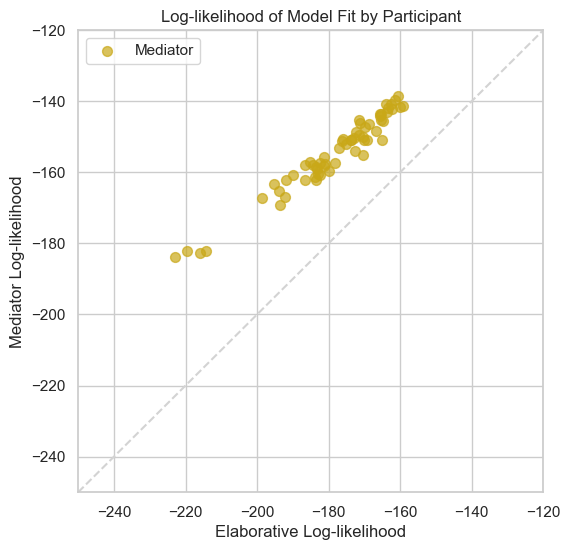

In [39]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([-320, -320], [-100, -100], "--")
for best, color in zip(BEST_, COLORS):
    idxs = np.where(best == BEST)
    # No legend will be generated if we don't pass label=species
    ax.scatter(
        elab_LL[idxs], med_LL[idxs], label=best,
        s=50, color=color, alpha=0.7
    )
    
_ = plt.xlabel("Elaborative Log-likelihood")
_ = plt.ylabel("Mediator Log-likelihood")
_ = plt.title("Log-likelihood of Model Fit by Participant")
_ = plt.xlim([-250, -120])
_ = plt.ylim([-250, -120])
_ = plt.show
ax.legend(loc = "upper left");
ax.axline((0,0), slope=1, linestyle="--", color='lightgrey')

In [ ]:
res = pd.read_csv("LL_model1.csv")
res

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


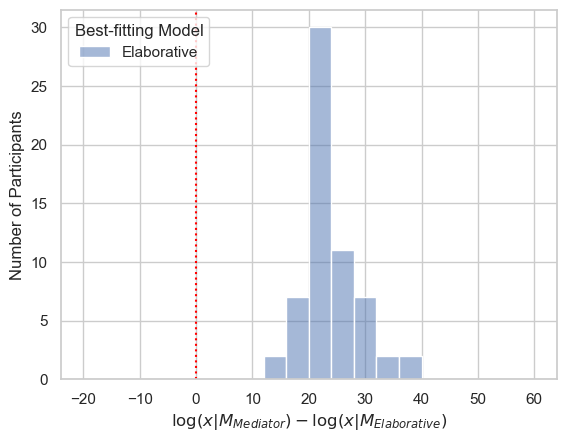

In [40]:
sns.histplot(result, x="diff.LL", hue="best.model", binwidth=4, binrange=[-20, 60], stat="count", legend="False")
plt.legend(loc="upper left", title="Best-fitting Model", labels=['Elaborative', 'Mediator'])
plt.xlabel("$\log(x|M_{Mediator}) - \log(x|M_{Elaborative})$") 
plt.ylabel("Number of Participants") 

plt.axvline(x=0, linestyle="dotted", color="red")
#plt.axvline(x=np.mean(res['diff.LL']), linestyle="dashed", color="blue", linewidth=2)
plt.show()

# Model Recovery

In [53]:
def policy(bprobs):
    """Selects an action based on a distribution of probabilities"""
    options = list(bprobs.keys())
    probs = [bprobs[opt] for opt in options]
    return np.random.choice(options, p=probs)

In [54]:
def create_memory(alldata):
    unique_cues = alldata.cue.unique()
    DM = {}
    for cue in unique_cues:
        littleDM = {}
        # make a set of all reponses given to a certain cue to be "vocab for that cue"
        for response in set(alldata[alldata.cue == cue].response):
            littleDM[response] = [0.01]
        DM[cue] = littleDM
    return DM

In [55]:
def learning_phase(alldata, pairs, errors, study, decay, temp, ter):
    # dataframe to store task results
    dataframe = []

    # create memory
    DM = create_memory(alldata)
    # learning phase
    time = 1
    errorResp = {}
    
    for cue in pairs.keys():
       if cue in errors:
          # Make a 'guess'
          options = DM[cue].keys()
          values = [activation(DM[cue][opt], time, decay) for opt in options]
          prob = boltzmann(options, values, temp)
          response = policy(prob)
          # if response is nan try again (response is np string)
          while response == "NaN" or response == "nan" or response == "None" or response == "":
            response = policy(prob)

          # Save the response
          errorResp[cue] = response

          # calculate response time
          response_time = responsetime(activation(DM[cue][response], time, decay), ter)
          response_time = round(response_time*1000, 0)

          # update dataframe
          dataframe += [['sim', 'learn', 1, cue, pairs[cue], response, response_time, pairs[cue] == response.upper()]]

          time +=5

          # Update the memory
          DM[cue][response] = [0.01, time]

          # Overwrite smaller activation of correct target to show task learning
          time +=5
          DM[cue][pairs[cue]] = [0.01, time]
       elif cue in study:
          time += 10
          DM[cue][pairs[cue]] = [0.01, time]
    time += 300 # time for distractor phase
    return DM, dataframe, errorResp, time

## Simulating Elaborative Retrieval 

In [56]:
def simulate_data_elab(alldata, decay=0.5, temp=1, ter=1, mas = 1.6):
    # create a list of error items
    errors = alldata[alldata.condition == 1].cue.unique().tolist()
    # create a list of study items
    study = alldata[alldata.condition == 2].cue.unique().tolist()
    pos = 1
    present = study[:]

    for word in errors:
        present.insert(pos, word)
        pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(alldata.cue.unique(),alldata.target.unique()):
      pairs[cue] = target

    DM, dataframe, errorResp, time = learning_phase(alldata, pairs, errors, study, decay, temp, ter)

    # shuffle cue words
    cue_shuffled = list(pairs.keys())
    random.shuffle(cue_shuffled)
    # testing phase
    for cue in cue_shuffled:
      condition = 1 if cue in errors else 2
      options = DM[cue].keys()

      # create spreading activation additional error component given size of cue's dec mem
      cueMem = len(DM[cue])
      add = (mas - np.log((cueMem + 1)/2)) - (mas - np.log((cueMem + 1)/1))

      values = [activation(DM[cue][opt], time, decay) if opt != pairs[cue] else activation(DM[cue][pairs[cue]], time, decay) + add for opt in options]
      prob = boltzmann(options, values, temp)
      response = policy(prob)

      # if response is nan try again (response is np string)
      while response == "NaN" or response == "nan" or response == "None" or response == "":
        response = policy(prob)

      if condition == 1:
        resp_activation = activation(DM[cue][response], time, decay) + add
      else: 
        resp_activation = activation(DM[cue][response], time, decay)
      
      response_time = responsetime(resp_activation, ter=ter)
      response_time = round(response_time*1000, 0)

      dataframe += [['sim', 'test', condition, cue, pairs[cue], response, response_time, pairs[cue]==response.upper()]] 

      # addtime taken to respond
      time += response_time/1000

    return pd.DataFrame(dataframe, columns=['participant', 'phase', 'condition', 'cue', 'target', 'response', 'rt',
       'correct'])

In [57]:
# test
data = alldata
data = simulate_data_elab(data)
data[data.phase == 'test'].correct.mean()

0.23333333333333334

In [58]:
opt.minimize(vLLelab, x0 = [0.5, 1, 1], method = "Powell", bounds=[[0.01, 2], [0, 2], [0.1, 2]])

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 154.79465301798092
       x: [ 4.813e-01  9.340e-01  1.274e+00]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00]]
    nfev: 87

## Simulating Mediator Retrievals

In [59]:
def calc_f(alldata):
    """Calculate mean proportion of correct responses for error trials in the data"""
    correct = 0
    total = 0
    alldata = alldata[(alldata.condition == 1) & (alldata.phase == "test")]
    for target, response in zip(alldata.target, alldata.response):
        if target == response:
            correct += 1
        total += 1
    return correct/total

In [60]:
f = calc_f(alldata)
f

0.5918032786885246

In [61]:
def simulate_data_med(alldata, decay=0.5, temp=1, ter=1):
    # start by calculating f
    f = calc_f(alldata)

    # create a list of error items
    errors = alldata[alldata.condition == 1].cue.unique().tolist()
    # create a list of study items
    study = alldata[alldata.condition == 2].cue.unique().tolist()
    pos = 1
    present = study[:]

    for word in errors:
        present.insert(pos, word)
        pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(alldata.cue.unique(), alldata.target.unique()):
        pairs[cue] = target

    DM, dataframe, errorResp, time = learning_phase(alldata, pairs, errors, study, decay, temp, ter)
 
    # testing phase
    for cue in pairs.keys():
        condition = 1 if cue in errors else 2
        options = DM[cue].keys()

        # calculate probability of retrieving given response
        values = [activation(DM[cue][opt], time, decay) for opt in options]
        prob = boltzmann(options, values, temp)
        response = policy(prob)

        # if response is nan try again (response is np string)
        while response == "NaN" or response == "nan" or response == "None" or response == "":
            response = policy(prob)

        # if retrieved error -- correct f proportion of the time
        if condition == 1:
            error = errorResp[cue]
            if response == error:
                response = pairs[cue] if np.random.rand() < f else response

        # add response times calculations
        # probability of given response time with
        # 
        if condition == 1:
            error = errorResp[cue]
            errorAct = activation(DM[cue][error], time, decay)
            error_rt = responsetime(errorAct, ter=0)
            time += (error_rt * 1000)
            respAct = activation(DM[cue][response], time, decay)
            resp_rt = responsetime(respAct, ter=ter)
            time += (resp_rt * 1000)
            response_time = resp_rt + error_rt
            response_time = round(response_time*1000, 0)
        else:
            response_time = responsetime(respAct, ter=ter)
            response_time = round(response_time*1000, 0)
            # addtime taken to respond
            time += response_time/1000
        
        dataframe += [['sim', 'test', condition, cue, pairs[cue], response, response_time, pairs[cue]==response.upper()]]

        
    
    return pd.DataFrame(dataframe, columns=['participant', 'phase', 'condition', 'cue', 'target', 'response', 'rt',
       'correct'])


In [62]:
data = simulate_data_med(data)
data

,participant,phase,condition,cue,target,response,rt,correct
0,sim,learn,1,EMPIRE,STATE,STATE,1995.0,True
1,sim,learn,1,CHUNK,BLOCK,BRICK,4315.0,False
2,sim,learn,1,GLIDE,HANG,wind,5581.0,False
3,sim,learn,1,SAIL,OCEAN,ocean,6567.0,True
4,sim,learn,1,ELEVATOR,BUILDING,button,7402.0,False
...,...,...,...,...,...,...,...,...
85,sim,test,2,STAR,NIGHT,NIGHT,7744047.0,True
86,sim,test,2,ANNUAL,PICNIC,PICNIC,7744047.0,True
87,sim,test,2,SOUTH,WEST,WEST,7744047.0,True
88,sim,test,2,CRITIC,ANALYZE,REVIEW,7744047.0,False


In [63]:
# test
data = simulate_data_med(data)
data[data.phase == 'test'].correct.mean()

0.8833333333333333

In [64]:
opt.minimize(vLLmed, x0 = [0.5, 1, 1], method = "Powell", bounds=[[0.01, 2], [0, 2], [0.1, 2]])

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 130.45731850494408
       x: [ 1.003e-02  2.000e+00  2.000e+00]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00]
           [ 8.262e-06 -1.686e-05 -1.686e-05]]
    nfev: 179

In [65]:
def model_recovery(sim_data):
    alpha, temp, ter = opt.minimize(vLLelab, x0 = [0.5, 0.5, 1], method = "Powell", bounds=[[0.25, 0.75], [0, 1], [0.1, 4]]).x
    elab = LLelabRT(sim_data, alpha, temp, ter)

    alpha, temp, ter = opt.minimize(vLLmed, x0 = [0.5, 0.5, 1], method = "Powell", bounds=[[0.25, 0.75], [0, 1], [0.1, 4]]).x
    med = LLmedRT(sim_data, alpha, temp, ter)

    best = "Mediator"
    if elab > med:
        best = "Elaborative"

    diff = med - elab

    return [alpha, temp, ter, elab, med, best, diff]

In [66]:
# turn off warnings for this cell
import warnings
warnings.filterwarnings('ignore')

DO_RECOVERY = True
recovery_df = []

# number of runs
n_runs = 10

if DO_RECOVERY:
    print("Running model recovery")
    global data
    for model in ["Elaborative", "Mediator"]:
        data = alldata
        decay = np.nan
        temp = np.nan
        ter = np.nan
        results = []
        for run in tqdm(range(n_runs)):
            #print(run)
            if model == "Elaborative":
                #randomizing parameters can break the code so we'll loop for success
                success = False
                while success == False:
                    try:
                        decay = np.random.uniform(0.25, 0.75)
                        temp = np.random.uniform(0, 1)
                        ter = np.random.uniform(0.1, 4)

                        # print(decay, temp, ter)
                        sim_data = simulate_data_elab(data, decay=decay, temp=temp, ter=ter)
                        data = sim_data
                        results = model_recovery(sim_data)

                        success = True
                    except:
                        success = False
            else:
                success = False
                while success == False:
                    try:
                        decay = np.random.uniform(0.25, 0.75)
                        temp = np.random.uniform(0, 1)
                        ter = np.random.uniform(0.1, 4)

                        # print(decay, temp, ter)
                        sim_data = simulate_data_med(data, decay=decay, temp=temp, ter=ter)
                        data = sim_data
                        results = model_recovery(sim_data)

                        success = True
                    except:
                        success = False
            
            row = [model, decay, temp, ter] + results
            recovery_df += [row]


Running model recovery


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [67]:
if DO_RECOVERY:
    recovery_df = pd.DataFrame(recovery_df, columns=["orig.model", "orig.decay", "orig.temp", "orig.ter",
                                                     "recov.delat", "recov.temp", "recov.ter", "elab.LL", "med.LL", "best.model", "diff.LL"])    
    # recovery_df.to_csv("model_recovery_new1.csv")
else:
    recovery_df = pd.read_csv("model_recovery_new1.csv")
recovery_df

,orig.model,orig.decay,orig.temp,orig.ter,recov.delat,recov.temp,recov.ter,elab.LL,med.LL,best.model,diff.LL
0,Elaborative,0.419754,0.155019,0.785336,0.749947,0.999934,3.999939,58.756026,-132.392353,Elaborative,-191.148379
1,Elaborative,0.661071,0.240357,3.374057,0.250053,0.999947,3.999939,30.253018,-120.608970,Elaborative,-150.861988
2,Elaborative,0.376029,0.182198,1.828991,0.749947,0.999934,3.999939,73.788750,-118.529409,Elaborative,-192.318159
3,Elaborative,0.487026,0.024050,3.877890,0.749947,0.999934,3.999939,19.584142,-115.756820,Elaborative,-135.340962
4,Elaborative,0.498960,0.773591,0.327778,0.250053,0.999947,3.999939,43.732667,-113.677778,Elaborative,-157.410445
5,Elaborative,0.624869,0.592943,0.173378,0.749947,0.999934,3.999939,38.843142,-112.984232,Elaborative,-151.827373
6,Elaborative,0.326437,0.582963,0.273213,0.749947,0.999934,3.999939,-133.932211,-112.291084,Mediator,21.641126
7,Elaborative,0.276556,0.829158,0.514497,0.749947,0.999934,3.999939,-133.932211,-112.291084,Mediator,21.641126
8,Elaborative,0.391590,0.225772,2.960050,0.749947,0.999934,3.999939,69.070275,-112.291084,Elaborative,-181.361360
9,Elaborative,0.647913,0.155161,3.783058,0.749947,0.999934,3.999939,39.182696,-112.291084,Elaborative,-151.473780


In [68]:
recovery_df = pd.DataFrame(recovery_df, columns=["orig.model", "orig.decay", "orig.temp", "orig.ter",
                                                     "recovered.decay", "recovered.temp", "recoverd.ter", 
                                                 "elab.LL", "med.LL", "best.model", "diff.LL"])
recovery_df

,orig.model,orig.decay,orig.temp,orig.ter,recovered.decay,recovered.temp,recoverd.ter,elab.LL,med.LL,best.model,diff.LL
0,Elaborative,0.419754,0.155019,0.785336,NaN,NaN,NaN,58.756026,-132.392353,Elaborative,-191.148379
1,Elaborative,0.661071,0.240357,3.374057,NaN,NaN,NaN,30.253018,-120.608970,Elaborative,-150.861988
2,Elaborative,0.376029,0.182198,1.828991,NaN,NaN,NaN,73.788750,-118.529409,Elaborative,-192.318159
3,Elaborative,0.487026,0.024050,3.877890,NaN,NaN,NaN,19.584142,-115.756820,Elaborative,-135.340962
4,Elaborative,0.498960,0.773591,0.327778,NaN,NaN,NaN,43.732667,-113.677778,Elaborative,-157.410445
5,Elaborative,0.624869,0.592943,0.173378,NaN,NaN,NaN,38.843142,-112.984232,Elaborative,-151.827373
6,Elaborative,0.326437,0.582963,0.273213,NaN,NaN,NaN,-133.932211,-112.291084,Mediator,21.641126
7,Elaborative,0.276556,0.829158,0.514497,NaN,NaN,NaN,-133.932211,-112.291084,Mediator,21.641126
8,Elaborative,0.391590,0.225772,2.960050,NaN,NaN,NaN,69.070275,-112.291084,Elaborative,-181.361360
9,Elaborative,0.647913,0.155161,3.783058,NaN,NaN,NaN,39.182696,-112.291084,Elaborative,-151.473780


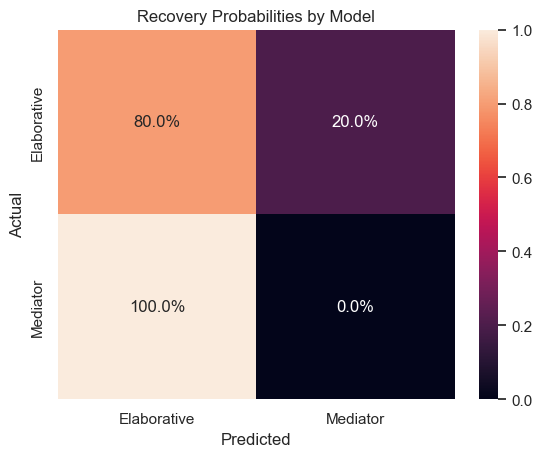

In [69]:
confusion_matrix = pd.crosstab(recovery_df['orig.model'], recovery_df['best.model'], rownames=['Actual'], colnames=['Predicted'], margins=False)
sns.heatmap(confusion_matrix/(10), annot=True, fmt=".1%")
plt.title("Recovery Probabilities by Model")
plt.savefig("model-recovery.png")
plt.show()

In [70]:
sim_data

,participant,phase,condition,cue,target,response,rt,correct
0,sim,learn,1,EMPIRE,STATE,STATE,1276.0,True
1,sim,learn,1,CHUNK,BLOCK,BLOCK,3530.0,True
2,sim,learn,1,GLIDE,HANG,HANG,4747.0,True
3,sim,learn,1,SAIL,OCEAN,OCEAN,5689.0,True
4,sim,learn,1,ELEVATOR,BUILDING,BUILDING,6487.0,True
...,...,...,...,...,...,...,...,...
85,sim,test,2,FREEWAY,ROAD,ROAD,5385963.0,True
86,sim,test,2,ASSISTANCE,HELPER,HELPER,5385963.0,True
87,sim,test,2,VALLEY,LOW,LOW,5385963.0,True
88,sim,test,2,GRADUATE,CAP,CAP,5385963.0,True


In [71]:
elab_score = recovery_df[recovery_df["orig.model"] == "Elaborative"]["best.model"].value_counts()
med_score = recovery_df[recovery_df["orig.model"] == "Mediator"]["best.model"].value_counts()
print('Elab:', elab_score)
print('Med:', med_score)

Elab: best.model
Elaborative    8
Mediator       2
Name: count, dtype: int64
Med: best.model
Elaborative    10
Name: count, dtype: int64
